In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from solardatatools import DataHandler
from solardatatools.dataio import load_redshift_data
from solardatatools.algorithms import Dilation
from spcqe.quantiles import make_basis_matrix

## Difference between np.mod and np.tile for non integer periods

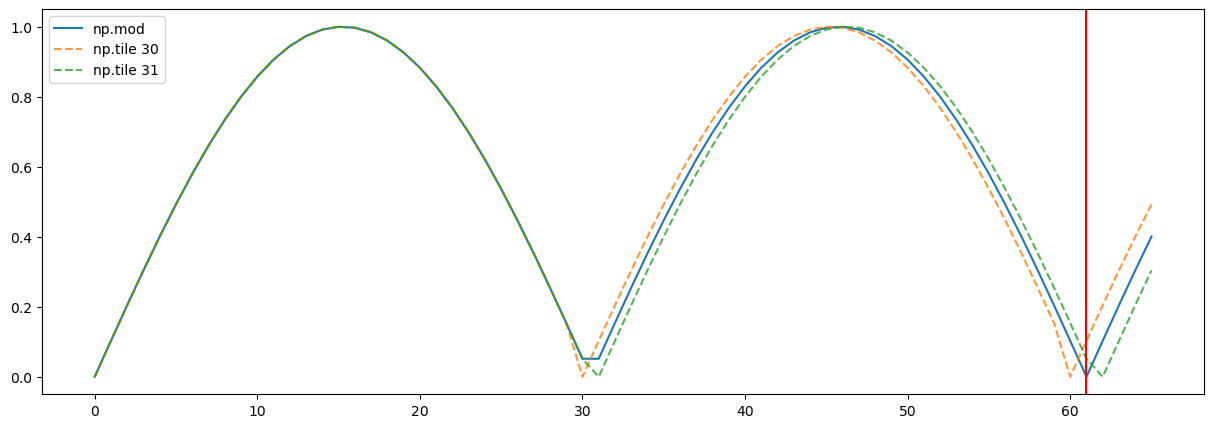

In [3]:
T = 30.5
N = int(2*T + 5)

t_values = np.arange(0, N, 1)

sig1 = np.sin(np.pi * np.mod(t_values, T) / T)
sig2 = np.sin(np.pi * t_values[:int(T)] / T)
multiplier = max(1, N // sig2.shape[0] + 1)
sig2 = np.tile(sig2, multiplier)[:N]
sig3 = np.sin(np.pi * t_values[:int(T)+1] / T)
multiplier = max(1, N // sig3.shape[0] + 1)
sig3 = np.tile(sig3, multiplier)[:N]

plt.figure(figsize=(15, 5))
plt.plot(t_values, sig1, label='np.mod')
plt.plot(t_values, sig2, label='np.tile ' + str(int(T)), linestyle='--', alpha=0.8)
plt.plot(t_values, sig3, label='np.tile ' + str(int(T)+1), linestyle='--', alpha=0.8)
plt.axvline(2*T, color='red')
plt.legend()
plt.show()

## Sample basis

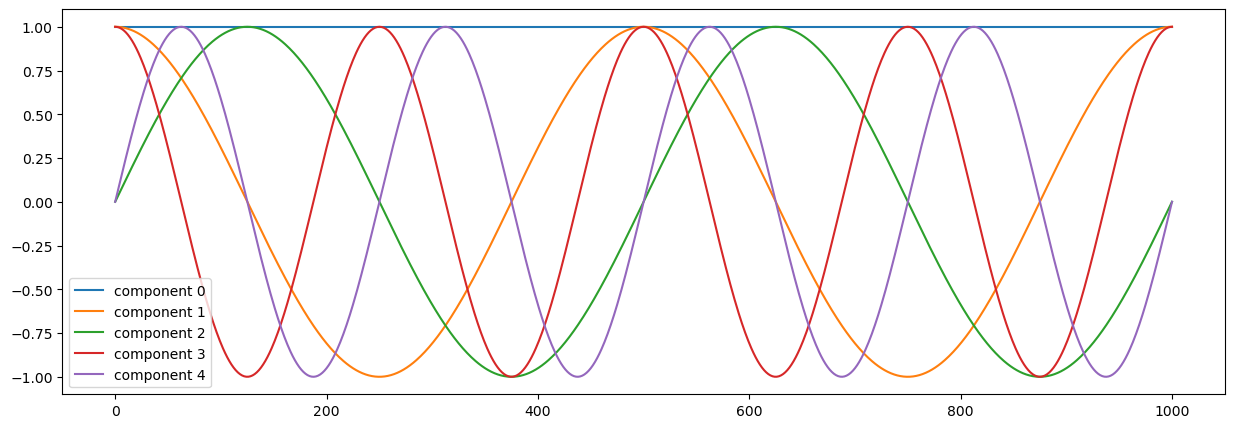

In [4]:
basis = make_basis_matrix(num_harmonics=2,
                           length=1000+1,
                           periods=500,
                           standing_wave=False,
                           trend=False,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

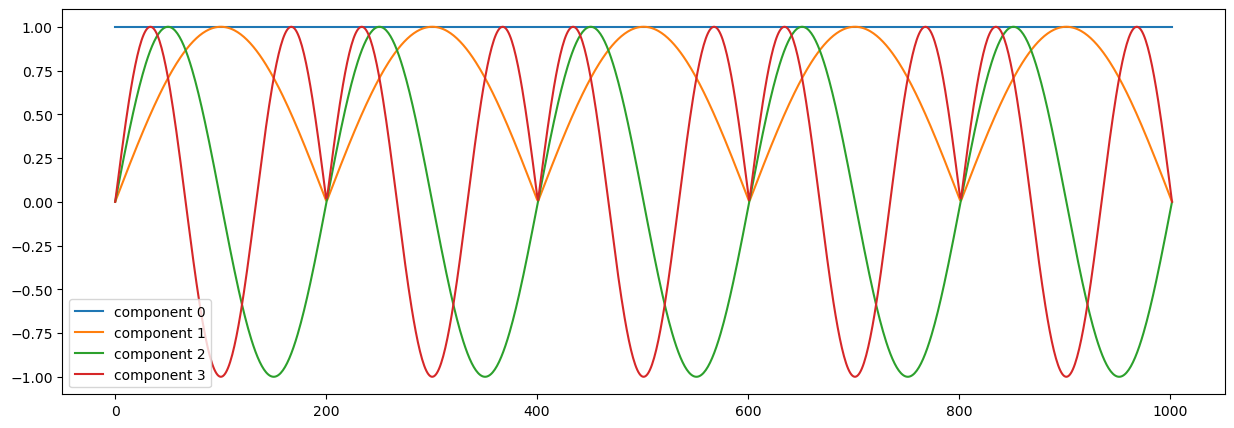

In [5]:
basis = make_basis_matrix(num_harmonics=3,
                           length=1002+1,
                           periods=200.4,
                           standing_wave=True,
                           trend=False,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

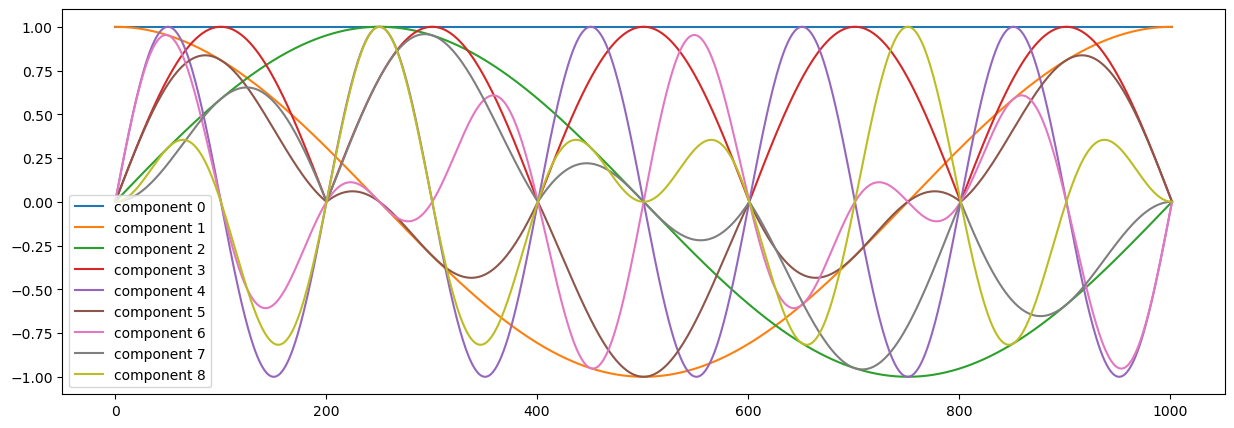

In [6]:
basis = make_basis_matrix(num_harmonics=[2, 1],
                          length=1002+1,
                          periods=[200.4, 1002],
                          standing_wave=[True, False],
                          trend=False,
                          max_cross_k=None,
                          custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

## With PV data

In [7]:
query = {
'siteid': "TADBC1078041",
'api_key': os.environ.get('REDSHIFT_API_KEY'),
'sensor': 0
}
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()

/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])



            *********************************************
            * Solar Data Tools Data Onboarding Pipeline *
            *********************************************

            This pipeline runs a series of preprocessing, cleaning, and quality
            control tasks on stand-alone PV power or irradiance time series data.
            After the pipeline is run, the data may be plotted, filtered, or
            further analyzed.

            Authors: Bennet Meyers and Sara Miskovich, SLAC

            (Tip: if you have a mosek [https://www.mosek.com/] license and have it
            installed on your system, try setting solver='MOSEK' for a speedup)

            This material is based upon work supported by the U.S. Department
            of Energy's Office of Energy Efficiency and Renewable Energy (EERE)
            under the Solar Energy Technologies Office Award Number 38529.

            


task list:   0%|                                          | 0/7 [00:00<?, ?it/s]/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[-1] >= thresh:
task list:  14%|████▊                             | 1/7 [00:00<00:03,  1.59it/s]/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/matrix_



total time: 90.33 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              27.64s
Cleaning                   1.08s
Filtering/Summarizing      61.61s
    Data quality           1.01s
    Clear day detect       1.45s
    Clipping detect        28.75s
    Capacity change detect 30.39s



In [8]:
nvals_dil = 101
dil = Dilation(dh)
sig = dil.signal_dil
ndays = len(sig) // nvals_dil

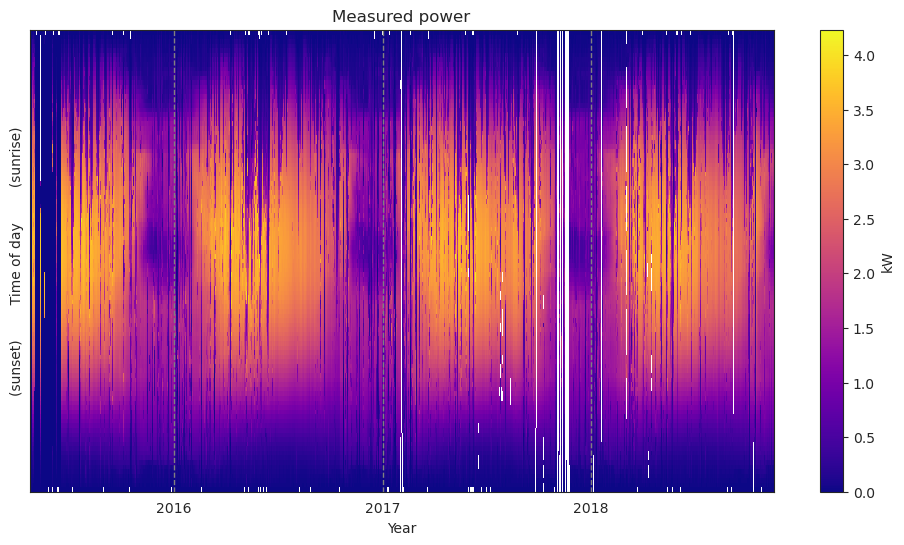

In [9]:
dil.plot_heatmap(space='dilated');

In [10]:
regular_basis = make_basis_matrix(
    num_harmonics=[2, 2],
    length=sig.shape[0],
    periods=[nvals_dil, 365.24225*nvals_dil],
    standing_wave=False,
    trend=False,
    max_cross_k=None,
    custom_basis=None
)

In [11]:
standing_wave_basis = make_basis_matrix(
    num_harmonics=[4, 2],
    length=sig.shape[0],
    periods=[nvals_dil, 365.24225*nvals_dil],
    standing_wave=[True, False],
    trend=False,
    max_cross_k=None,
    custom_basis=None
)

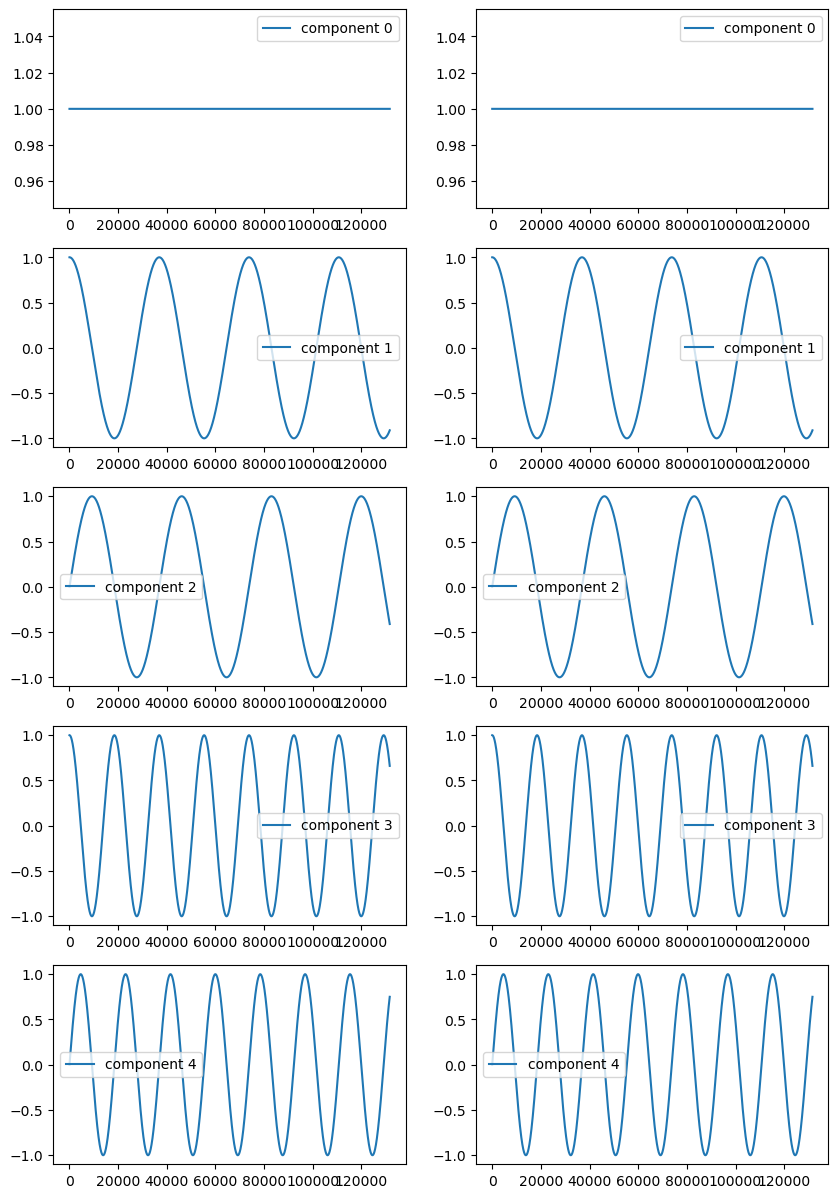

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    ax[i, 0].plot(regular_basis[:, i], label=f'component {i}')
    ax[i, 1].plot(standing_wave_basis[:, i], label=f'component {i}')
    ax[i, 0].legend()
    ax[i, 1].legend()
plt.show()

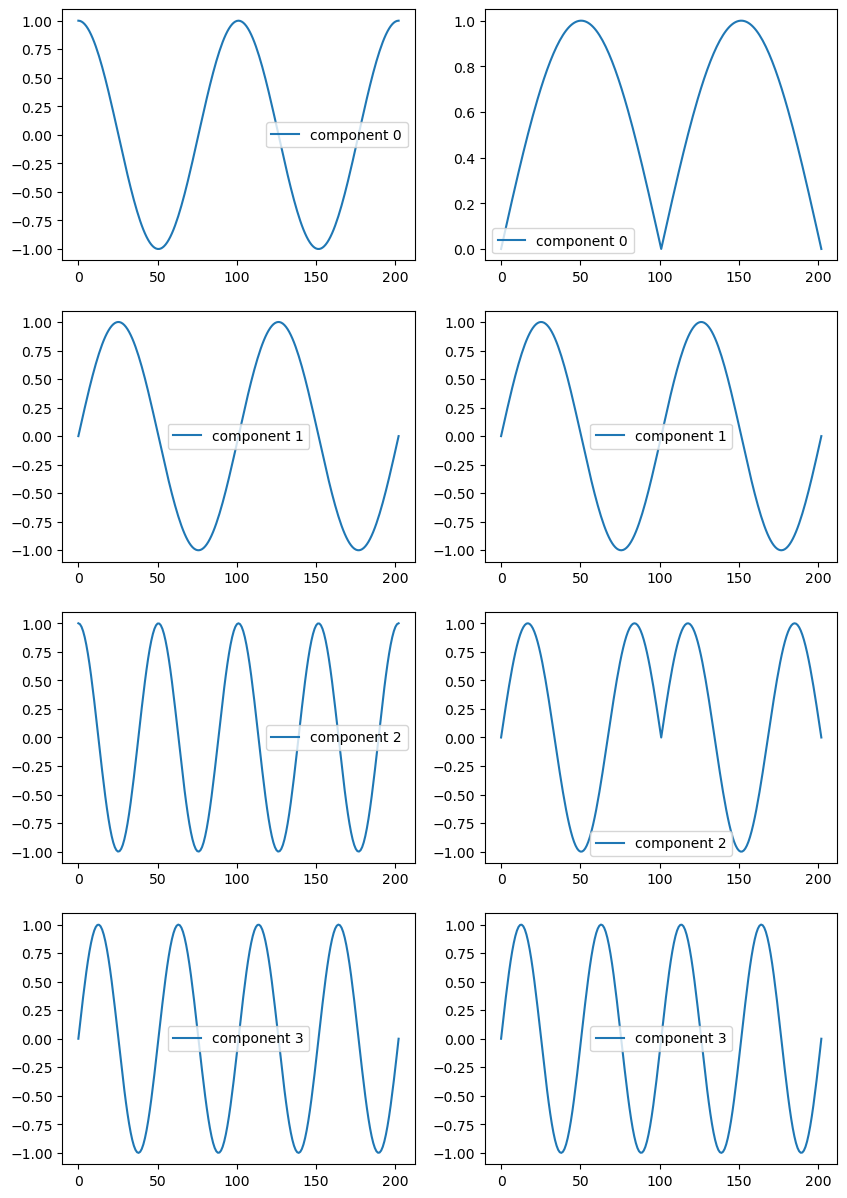

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(10, 15))
for i in range(4):
    ax[i, 0].plot(regular_basis[0:nvals_dil*2 + 1, i+5], label=f'component {i}')
    ax[i, 1].plot(standing_wave_basis[0:nvals_dil*2 + 1, i+5], label=f'component {i}')
    ax[i, 0].legend()
    ax[i, 1].legend()
plt.show()

## Checking if custom basis works

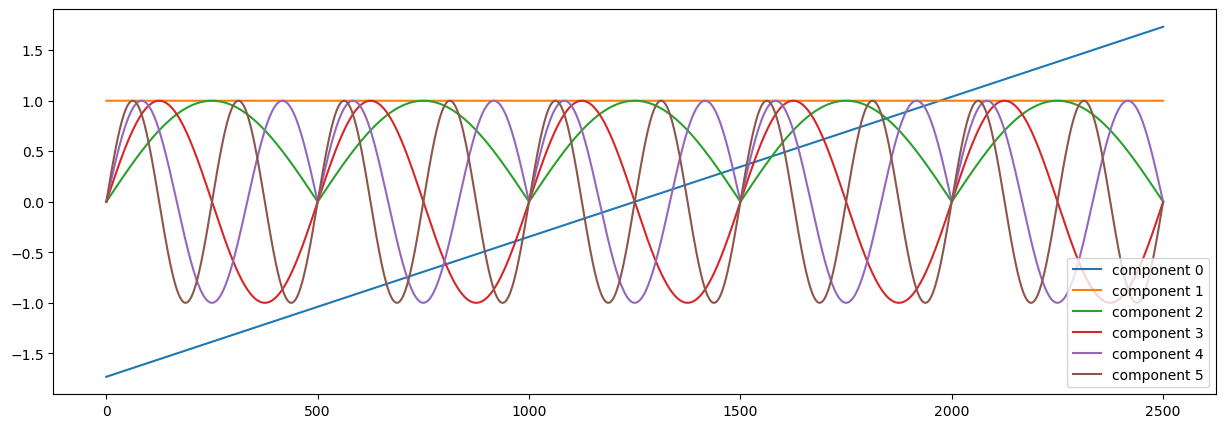

In [14]:
basis1 = make_basis_matrix(num_harmonics=4,
                           length=2500+1,
                           periods=500,
                           standing_wave=True,
                           trend=True,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis1.shape[1]):
    plt.plot(basis1[:, i], label=f'component {i}')
plt.legend()
plt.show()

In [15]:
def make_sine_only_basis(length, period, num_harmonics, tstart=0):
    w = 2 * np.pi / (period * 2)
    i_value = np.arange(1, num_harmonics + 1)[:, np.newaxis]
    t_values = np.arange(period) + tstart
    B_sin = np.sin(i_value * w * t_values).T
    B_fourier = np.empty((length, num_harmonics), dtype=float)
    multiplier = max(1, length // B_sin.shape[0] + 1)
    B_fourier = np.tile(B_sin, (multiplier, 1))[:length]
    return B_fourier

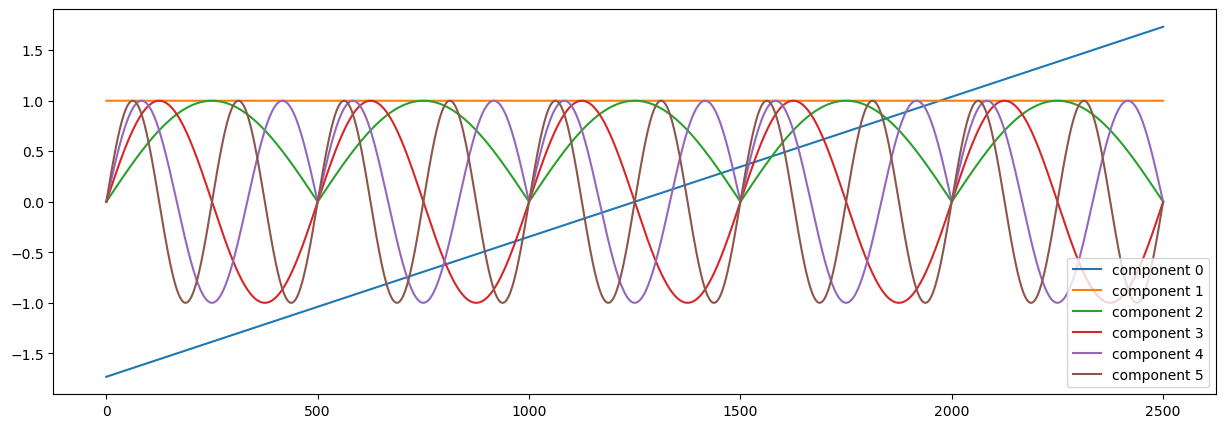

In [16]:
my_custom_basis = make_sine_only_basis(500, 500, 4)
basis2 = make_basis_matrix(num_harmonics=1,
                           length=2500+1,
                           periods=10,
                           standing_wave=False,
                           trend=True,
                           max_cross_k=None,
                           custom_basis={0: my_custom_basis})
plt.figure(figsize=(15, 5))
for i in range(basis2.shape[1]):
    plt.plot(basis2[:, i], label=f'component {i}')
plt.legend()
plt.show()

In [17]:
(basis1==basis2).all()

True